In [1]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import random
import shutil
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# Base directories
base_dir = r"E:\Datasets\Vision\Sideguide\Polygon(surface)\Extracted"
output_dir = r"E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg"

# Dataset split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Use a subset of data for faster processing (set to 1.0 to use all data)
data_fraction = 1.0

# Create output directories
os.makedirs(output_dir, exist_ok=True)

In [4]:
def convert_polygon_to_yolo(points_str, width, height):
    """Convert CVAT polygon points to YOLO normalized format"""
    # Parse points string to coordinates
    # CVAT format is "x1,y1;x2,y2;..." 
    points = []
    for point_pair in points_str.split(';'):
        if point_pair:
            x, y = map(float, point_pair.split(','))
            # Normalize coordinates
            x_norm = x / width
            y_norm = y / height
            points.extend([x_norm, y_norm])
    
    return points

def create_output_dirs():
    """Create the required directory structure for YOLO segmentation"""
    os.makedirs(os.path.join(output_dir, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "train", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "valid", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "valid", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", "labels"), exist_ok=True)

In [5]:
def find_all_files():
    """Find all XML and image files in the dataset structure"""
    xml_files = []
    image_files = []
    
    # Iterate through all surface folders
    for surface_folder in tqdm(os.listdir(base_dir), desc="Scanning main folders"):
        surface_path = os.path.join(base_dir, surface_folder)
        if not os.path.isdir(surface_path):
            continue
        
        # Iterate through all sub-folders
        for subfolder in tqdm(os.listdir(surface_path), 
                             desc=f"Scanning {surface_folder}", leave=False):
            subfolder_path = os.path.join(surface_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            
            # Find XML files
            for file in os.listdir(subfolder_path):
                if file.endswith(".xml"):
                    xml_files.append(os.path.join(subfolder_path, file))
            
            # Find image files
            for file in os.listdir(subfolder_path):
                if file.endswith((".jpg", ".jpeg", ".png")) and not file.startswith("._"):
                    image_files.append(os.path.join(subfolder_path, file))
    
    print(f"Found {len(xml_files)} XML files and {len(image_files)} images")
    return xml_files, image_files

# Execute the function
xml_files, image_files = find_all_files()

# Apply data fraction if needed
if data_fraction < 1.0:
    random.shuffle(xml_files)
    xml_files = xml_files[:int(len(xml_files) * data_fraction)]
    print(f"Using {len(xml_files)} XML files ({data_fraction*100:.1f}% of total)")

Scanning main folders:   0%|          | 0/5 [00:00<?, ?it/s]

Scanning Surface_1:   0%|          | 0/130 [00:00<?, ?it/s]

Scanning Surface_2:   0%|          | 0/170 [00:00<?, ?it/s]

Scanning Surface_3:   0%|          | 0/170 [00:00<?, ?it/s]

Scanning Surface_4:   0%|          | 0/160 [00:00<?, ?it/s]

Scanning Surface_5:   0%|          | 0/170 [00:00<?, ?it/s]

Found 800 XML files and 46399 images


In [6]:
def process_cvat_xml(xml_files, image_files):
    """Process CVAT format XML files and extract class information and polygon data"""
    all_classes = set()
    dataset = []
    
    # Create image lookup dictionary
    image_lookup = {}
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        image_lookup[img_name] = img_path
    
    # Process each XML file
    for xml_file in tqdm(xml_files, desc="Processing XML files"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # Extract class labels from the task section
            labels_section = root.find('.//task/labels')
            if labels_section:
                for label in labels_section.findall('.//label/name'):
                    all_classes.add(label.text)
            
            # Process each image annotation
            for image in root.findall('.//image'):
                img_name = image.get('name')
                width = int(image.get('width', 1920))  # Default to 1920 if not specified
                height = int(image.get('height', 1080))  # Default to 1080 if not specified
                
                # Find corresponding image file
                img_path = image_lookup.get(img_name)
                if not img_path:
                    continue
                
                # Extract polygons for this image
                polygons = []
                for polygon in image.findall('polygon'):
                    label = polygon.get('label')
                    points = polygon.get('points')
                    
                    if label and points:
                        all_classes.add(label)
                        polygons.append({
                            'class': label,
                            'points': points
                        })
                
                if polygons:
                    dataset.append({
                        'xml_file': xml_file,
                        'img_file': img_path,
                        'width': width,
                        'height': height,
                        'polygons': polygons
                    })
        except Exception as e:
            print(f"Error processing {xml_file}: {e}")
    
    return list(all_classes), dataset

# Execute the function
classes, dataset = process_cvat_xml(xml_files, image_files)

# Sort classes alphabetically
classes = sorted(classes)
print(f"Found {len(classes)} unique classes: {classes}")
print(f"Successfully processed {len(dataset)} images with polygon annotations")

Processing XML files:   0%|          | 0/800 [00:00<?, ?it/s]

Found 6 unique classes: ['alley', 'bike_lane', 'braille_guide_blocks', 'caution_zone', 'roadway', 'sidewalk']
Successfully processed 46396 images with polygon annotations


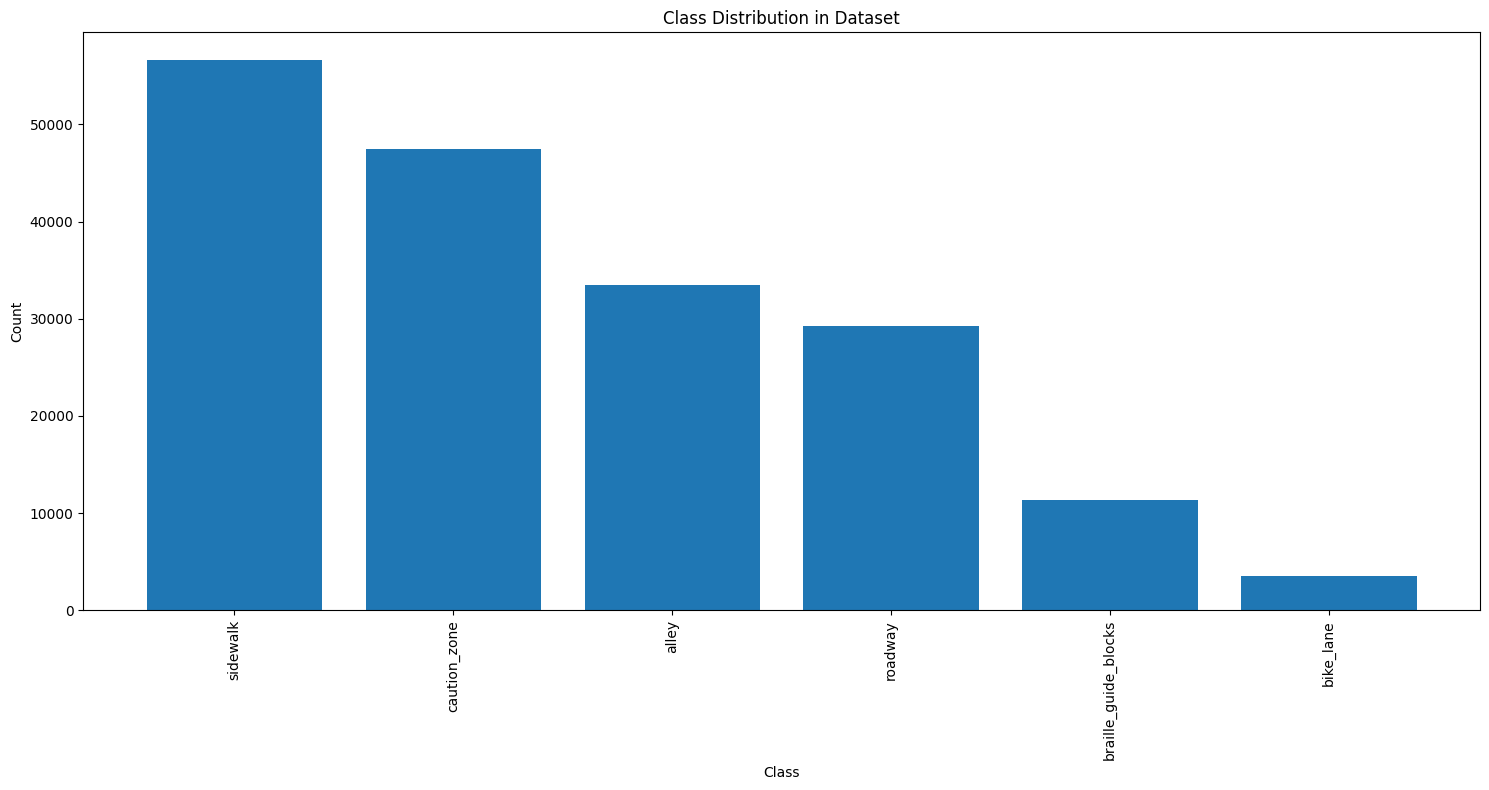

Class distribution:
sidewalk: 56644 (31.16%)
caution_zone: 47452 (26.10%)
alley: 33476 (18.41%)
roadway: 29250 (16.09%)
braille_guide_blocks: 11389 (6.26%)
bike_lane: 3585 (1.97%)


In [7]:
# Count class occurrences
class_counts = {}
for item in dataset:
    for polygon in item['polygons']:
        class_name = polygon['class']
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

# Sort by frequency
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualize class distribution
plt.figure(figsize=(15, 8))
plt.bar([x[0] for x in sorted_counts], [x[1] for x in sorted_counts])
plt.xticks(rotation=90)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print class distribution
print("Class distribution:")
total = sum(class_counts.values())
for cls, count in sorted_counts:
    print(f"{cls}: {count} ({count/total*100:.2f}%)")

In [8]:
def stratified_split(dataset, classes, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """Perform a stratified split based on polygon classes"""
    # Create per-class file lists
    class_files = {cls: [] for cls in classes}
    
    for i, item in enumerate(dataset):
        item_classes = set(polygon['class'] for polygon in item['polygons'])
        for cls in item_classes:
            class_files[cls].append(i)
    
    # Create empty sets for each split
    train_indices = set()
    val_indices = set()
    test_indices = set()
    
    # For each class, split its files according to the ratios
    for cls, indices in class_files.items():
        # Shuffle the indices for this class
        random.shuffle(indices)
        
        # Calculate split sizes
        n_samples = len(indices)
        n_train = int(n_samples * train_ratio)
        n_val = int(n_samples * val_ratio)
        
        # Split the indices
        cls_train = indices[:n_train]
        cls_val = indices[n_train:n_train + n_val]
        cls_test = indices[n_train + n_val:]
        
        # Add indices to the respective sets
        train_indices.update(cls_train)
        val_indices.update(cls_val)
        test_indices.update(cls_test)
    
    # Prioritize smaller sets to resolve overlaps
    val_indices = val_indices - train_indices
    test_indices = test_indices - train_indices - val_indices
    
    # Create the final split datasets
    train_data = [dataset[i] for i in train_indices]
    val_data = [dataset[i] for i in val_indices]
    test_data = [dataset[i] for i in test_indices]
    
    return train_data, val_data, test_data

# Split the dataset
train_data, val_data, test_data = stratified_split(dataset, classes, train_ratio, val_ratio, test_ratio)

print(f"Split dataset into:")
print(f"- Training: {len(train_data)} items ({len(train_data)/len(dataset)*100:.1f}%)")
print(f"- Validation: {len(val_data)} items ({len(val_data)/len(dataset)*100:.1f}%)")
print(f"- Testing: {len(test_data)} items ({len(test_data)/len(dataset)*100:.1f}%)")

Split dataset into:
- Training: 43581 items (93.9%)
- Validation: 1642 items (3.5%)
- Testing: 1173 items (2.5%)


In [9]:
# Create the YOLO format directory structure
create_output_dirs()

# Create class mapping (class name to index)
class_mapping = {cls: idx for idx, cls in enumerate(classes)}

print(f"Created directory structure for YOLO training")
print(f"Class mapping: {class_mapping}")

Created directory structure for YOLO training
Class mapping: {'alley': 0, 'bike_lane': 1, 'braille_guide_blocks': 2, 'caution_zone': 3, 'roadway': 4, 'sidewalk': 5}


In [10]:
def convert_to_yolo_format(item, output_dir, split_type, class_mapping):
    """Convert a single item to YOLO segmentation format"""
    img_file = item['img_file']
    width = item['width']
    height = item['height']
    polygons = item['polygons']
    
    # Create output paths
    img_basename = os.path.basename(img_file)
    img_name_no_ext = os.path.splitext(img_basename)[0]
    
    output_img_dir = os.path.join(output_dir, split_type, "images")
    output_label_dir = os.path.join(output_dir, split_type, "labels")
    
    output_img_path = os.path.join(output_img_dir, img_basename)
    output_label_path = os.path.join(output_label_dir, f"{img_name_no_ext}.txt")
    
    # Skip if already converted
    if os.path.exists(output_label_path):
        return True
    
    # Copy image
    try:
        shutil.copy2(img_file, output_img_path)
    except Exception as e:
        print(f"Error copying image {img_file}: {e}")
        return False
    
    # Create YOLO format label file
    try:
        with open(output_label_path, 'w') as f:
            for polygon in polygons:
                cls = polygon['class']
                if cls not in class_mapping:
                    continue
                
                cls_id = class_mapping[cls]
                points = polygon['points']
                
                # Convert to YOLO format
                yolo_coords = convert_polygon_to_yolo(points, width, height)
                
                if len(yolo_coords) < 6:  # Need at least 3 points (x,y pairs)
                    continue
                
                # Write to file: class_id x1 y1 x2 y2 ...
                f.write(f"{cls_id} " + " ".join(map(str, yolo_coords)) + "\n")
        return True
    except Exception as e:
        print(f"Error creating label for {img_file}: {e}")
        return False

# Process training data
print("Converting training data...")
train_success = 0
for item in tqdm(train_data, desc="Processing training data"):
    if convert_to_yolo_format(item, output_dir, "train", class_mapping):
        train_success += 1

# Process validation data
print("Converting validation data...")
val_success = 0
for item in tqdm(val_data, desc="Processing validation data"):
    if convert_to_yolo_format(item, output_dir, "valid", class_mapping):
        val_success += 1

# Process test data
print("Converting test data...")
test_success = 0
for item in tqdm(test_data, desc="Processing test data"):
    if convert_to_yolo_format(item, output_dir, "test", class_mapping):
        test_success += 1

print(f"Successfully converted:")
print(f"- Training: {train_success}/{len(train_data)} items")
print(f"- Validation: {val_success}/{len(val_data)} items")
print(f"- Testing: {test_success}/{len(test_data)} items")

Converting training data...


Processing training data:   0%|          | 0/43581 [00:00<?, ?it/s]

Converting validation data...


Processing validation data:   0%|          | 0/1642 [00:00<?, ?it/s]

Converting test data...


Processing test data:   0%|          | 0/1173 [00:00<?, ?it/s]

Successfully converted:
- Training: 43581/43581 items
- Validation: 1642/1642 items
- Testing: 1173/1173 items


In [11]:
# Create data.yaml file
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    f.write(f"train: ./train/images\n")
    f.write(f"val: ./valid/images\n")
    f.write(f"test: ./test/images\n\n")
    f.write(f"nc: {len(classes)}\n")
    f.write(f"names: {str(classes)}\n")

print(f"Dataset prepared in {output_dir}")
print(f"Created data.yaml with {len(classes)} classes")

Dataset prepared in E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg
Created data.yaml with 6 classes


Found 43581 images in E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\train\images
Visualizing E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\train\images\MP_SEL_SUR_031498.jpg with labels from E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\train\labels\MP_SEL_SUR_031498.txt


C:\Users\malla\AppData\Local\Temp\ipykernel_10356\4164824137.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(class_names)).colors * 255


Processing 5 polygons in E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\train\labels\MP_SEL_SUR_031498.txt
Successfully drew 5 polygons
Visualizing E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\train\images\MP_SEL_SUR_027847.jpg with labels from E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\train\labels\MP_SEL_SUR_027847.txt
Processing 5 polygons in E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\train\labels\MP_SEL_SUR_027847.txt
Successfully drew 5 polygons
Found 1642 images in E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\valid\images
Visualizing E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\valid\images\MP_SEL_SUR_046468.jpg with labels from E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\valid\labels\MP_SEL_SUR_046468.txt
Processing 1 polygons in E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\valid\labels\MP_SEL_SUR_046468.txt
Successfully drew 1 polygons
Visualizing E:\Datasets\Vision\Sideguide\Dataset\YOLO_Seg\valid\images\MP_SEL_SUR_007423.jpg with labels from E:\Datasets\Vision\Side

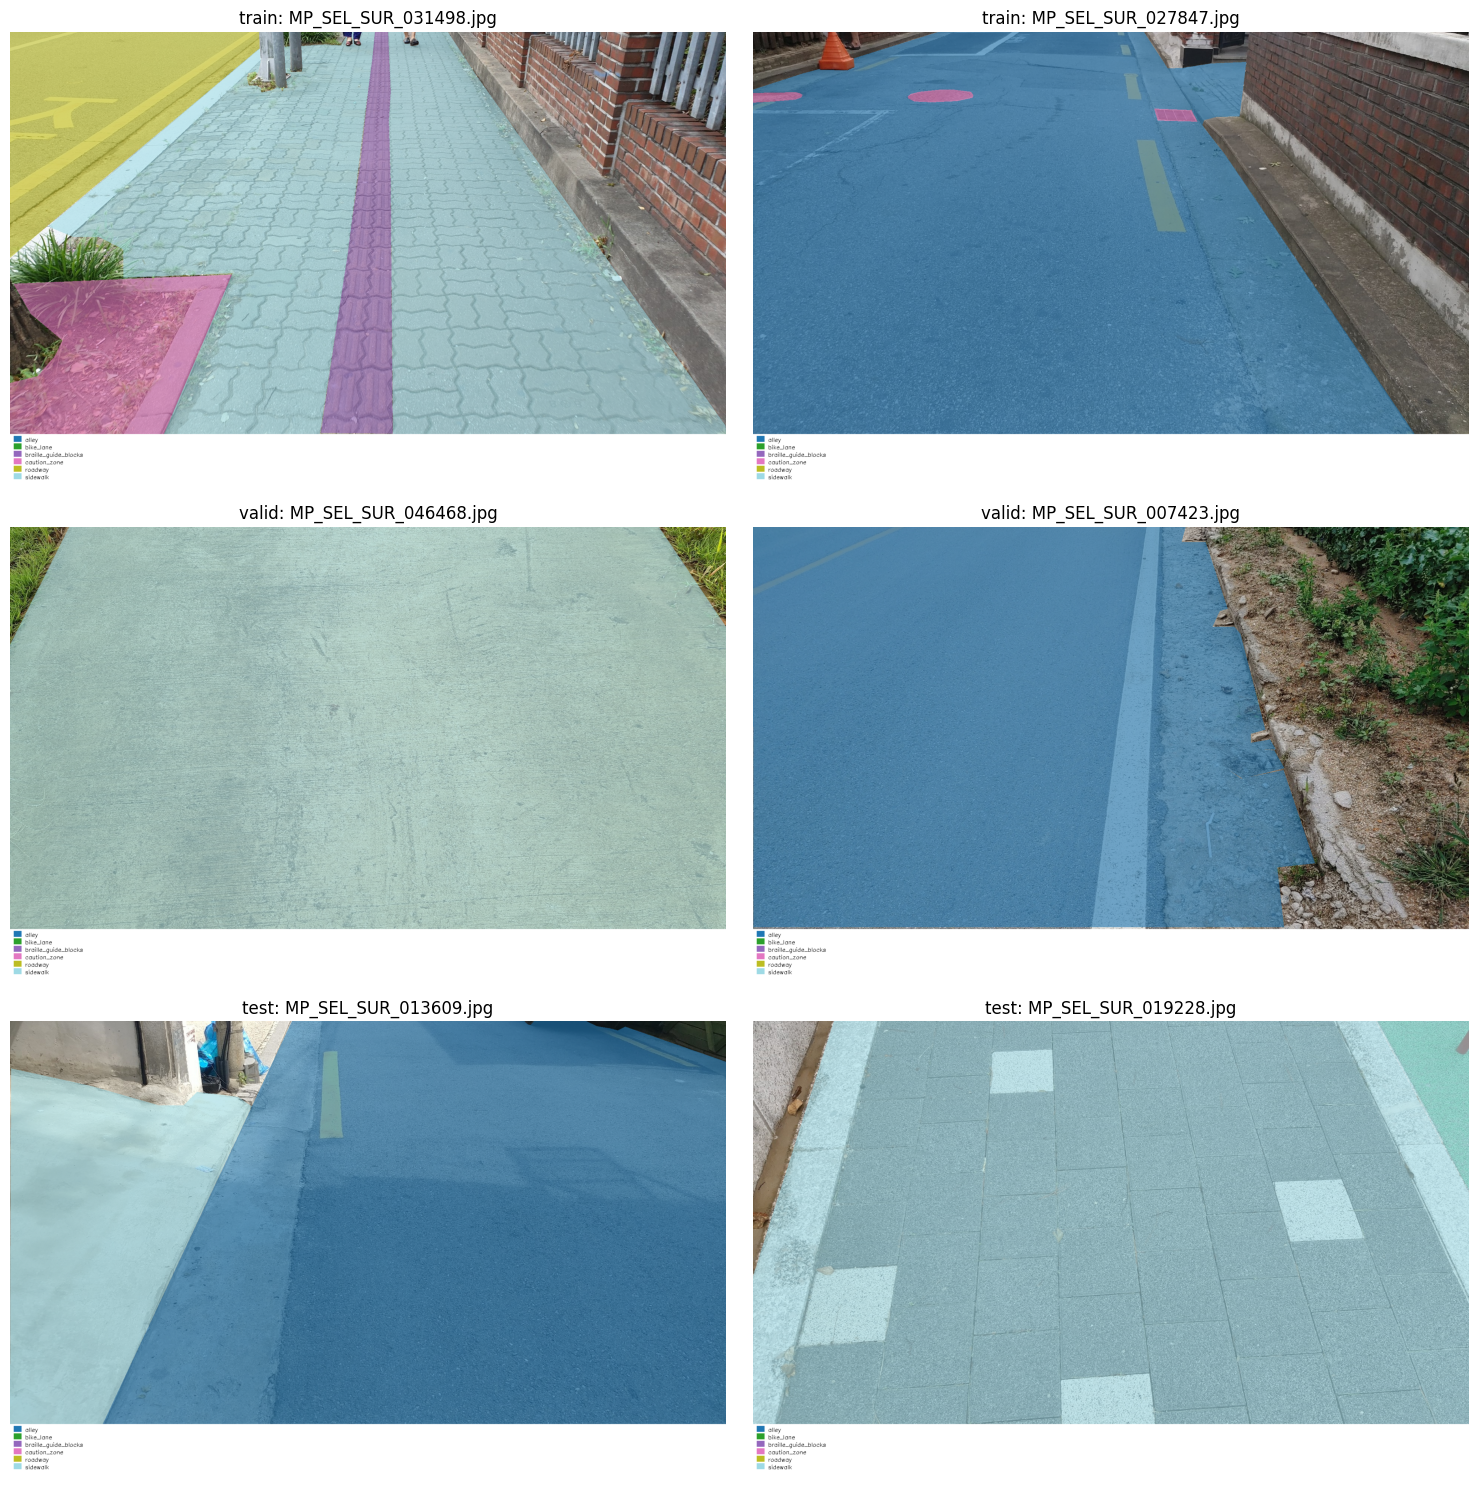

In [14]:
def visualize_yolo_segmentation(img_path, label_path, class_names):
    """Visualize YOLO format segmentation annotations on an image"""
    if not os.path.exists(img_path) or not os.path.exists(label_path):
        print(f"Image or label file not found: {img_path}, {label_path}")
        return
    
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    # Create a visualization image
    vis_img = img.copy()
    
    # Random colors for classes
    colors = plt.cm.get_cmap('tab20', len(class_names)).colors * 255
    
    # Read label file
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    print(f"Processing {len(lines)} polygons in {label_path}")
    
    polygon_count = 0
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 7:  # Need at least class_id and 3 points (x,y pairs)
            print(f"Skipping line with insufficient points: {line.strip()}")
            continue
            
        cls_id = int(parts[0])
        polygon_points = list(map(float, parts[1:]))
        
        # Denormalize coordinates
        points = []
        for i in range(0, len(polygon_points), 2):
            if i+1 < len(polygon_points):
                x = int(polygon_points[i] * width)
                y = int(polygon_points[i+1] * height)
                points.append([x, y])
        
        if len(points) < 3:
            print(f"Skipping polygon with fewer than 3 points")
            continue
            
        # Convert to numpy array for OpenCV
        points = np.array(points, dtype=np.int32)
        
        # Draw filled polygon
        color = tuple(map(int, colors[cls_id % len(colors)]))
        cv2.fillPoly(vis_img, [points], color)
        polygon_count += 1
    
    print(f"Successfully drew {polygon_count} polygons")
    
    # Blend with original image - use lower alpha for more visible masks
    alpha = 0.6  # Increased from 0.5 for better visibility
    blended = cv2.addWeighted(vis_img, alpha, img, 1-alpha, 0)
    
    # Add legend
    legend_height = min(30 + len(class_names) * 20, 200)  # Limit legend height
    legend_img = np.ones((legend_height, width, 3), dtype=np.uint8) * 255
    y_offset = 20
    for i, cls_name in enumerate(class_names):
        if i >= len(colors):
            break
        color = tuple(map(int, colors[i % len(colors)]))
        cv2.rectangle(legend_img, (10, y_offset-15), (30, y_offset), color, -1)
        cv2.putText(legend_img, cls_name, (40, y_offset), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
        y_offset += 20
        if y_offset > legend_height - 10:
            break
    
    # Combine image and legend
    result = np.vstack([blended, legend_img])
    
    return result

def visualize_random_samples(output_dir, class_names, num_samples=2):
    """Visualize random samples from each split"""
    splits = ["train", "valid", "test"]
    
    plt.figure(figsize=(15, 5*len(splits)))
    
    for i, split in enumerate(splits):
        img_dir = os.path.join(output_dir, split, "images")
        label_dir = os.path.join(output_dir, split, "labels")
        
        if not os.path.exists(img_dir):
            print(f"Directory not found: {img_dir}")
            continue
            
        if len(os.listdir(img_dir)) == 0:
            print(f"No images in {img_dir}")
            continue
            
        img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        if len(img_files) == 0:
            print(f"No image files found in {img_dir}")
            continue
        
        print(f"Found {len(img_files)} images in {img_dir}")
            
        # Select random samples
        samples = random.sample(img_files, min(num_samples, len(img_files)))
        
        for j, img_file in enumerate(samples):
            img_path = os.path.join(img_dir, img_file)
            label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
            
            print(f"Visualizing {img_path} with labels from {label_path}")
            
            vis_img = visualize_yolo_segmentation(img_path, label_path, class_names)
            
            if vis_img is not None:
                plt.subplot(len(splits), num_samples, i*num_samples + j + 1)
                plt.imshow(vis_img)
                plt.title(f"{split}: {img_file}")
                plt.axis('off')
            else:
                print(f"Failed to create visualization for {img_path}")
    
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_random_samples("path/to/YOLO_Seg", ["background", "sidewalk", "roadway", "bike_lane", "caution_zone", "braille_guide_blocks", "alley"], 2)
visualize_random_samples(output_dir, classes, 2)